# Arctic Sea surface Salinity from satellite data

Satellite remote sensing 
- repository https://doi.org/10.20350%2FdigitalCSIC%2F12620
- 2011 to 2019
- daily data 

Compared with HIST_KN CGRF run (C524.06)

- Montlhy climatologies

- Regional annual cycles


Notes

- Avereage over different numbers of years:
    - satelite does not see below ice, so area with ice cover varying year to year has average over less than 9 years
    - mask NAA first and then average to get same number of years?

From monthly climatologies:
- NAA too fresh in high Arctic,
- too salty at lower latitudes and inflow regions (eg Chucchi after june)
- Line in N. Atlantic with important change in SSS in NAA : impact of difference in atmospheric forcing?

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator
import matplotlib.patches as mpatches
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta
from glob import glob 

from sys import path as syspath
syspath.append('../')
import mapPlots as mplt

%load_ext autoreload
%autoreload 2

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(dashboard_address=':8188',n_workers=16, threads_per_worker=1)
client = Client(cluster)

http://127.0.0.1:8188/status

In [12]:
cluster.close()
client.close()

## Load satellite and model data

In [3]:
satDir='/home/ahaddon/data/SSS/'
satdata =xr.open_mfdataset(satDir+'*.nc', parallel=True)
# remove feb 29 because NAA doesn't have
satdata=satdata.drop_sel(time=satdata.time.sel(time='2012-02-29')).drop_sel(time=satdata.time.sel(time='2016-02-29'))
satdata

<xarray.Dataset>
Dimensions:      (time: 3273, y: 432, x: 432)
Coordinates:
  * time         (time) datetime64[ns] 2011-01-05T22:05:30 ... 2019-12-23T12:...
  * y            (y) float32 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * x            (x) float32 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
    lat          (y, x) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon          (y, x) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    crs          (time) int32 dask.array<chunksize=(27,), meta=np.ndarray>
    sss          (time, y, x) float32 dask.array<chunksize=(14, 216, 216), meta=np.ndarray>
    sss_error    (time, y, x) float32 dask.array<chunksize=(14, 216, 216), meta=np.ndarray>
    sss_anomaly  (time, y, x) float32 dask.array<chunksize=(14, 216, 216), meta=np.ndarray>
    sss_flag     (time, y, x) float32 dask.array<chunksize=(27, 432, 432), meta=np.ndarray>
Attributes: (12/48)
    title:                     Arctic Sea Surface Salinity L3 map
    institution:               Barcelona Expert Center (BEC), ICM-CSIC, Barce...
    institution_url:           http://bec.icm.csic.es
    summary:                   This dataset contains 9-day Level-3 Arctic sea...
    comment:                   These data were produced at BEC as part of the...
    source:                    SMOS L1B version 6.21
    ...                        ...
    sensor:                    SMOS/MIRAS
    spatial_resolution:        35km at nadir
    license:                   This product is distributed under Creative Com...
    license_url:               https://creativecommons.org/licenses/by/4.0/
    copyright:                 If this data is used for publication, the foll...
    doi:                       10.20350/digitalCSIC/12620

In [4]:
scenario = 'HIST_KN_CGRF_ORAS025_C524.06'
timeperiod = slice('2011-01-05','2019-12-23')

# Mesh
dmesh = xr.open_dataset('/tsanta/ahaddon/NAA/mesh/mesh_mask_naa1_rn_hmin7.nc')
landMask = dmesh.tmask.isel(t=0, z= 0)
didj_NAA = (dmesh.e1t * dmesh.e2t).isel(t=0).where((landMask>0)) # for area integrals, over ocean surface 

# Historical 
datadir = '/tsanta/ahaddon/data/'+scenario+'/'
NAAdata = xr.open_mfdataset(datadir+'NAA_*_biolog.nc',combine='by_coords',parallel=True).sel(time_counter=timeperiod).SSS
NAAdata=NAAdata.rename({'time_counter':'time'})
NAAdata['time']=satdata.time
NAAdata

<xarray.DataArray 'SSS' (time: 3273, y: 400, x: 568)>
dask.array<getitem, shape=(3273, 400, 568), dtype=float32, chunksize=(41, 134, 190), chunktype=numpy.ndarray>
Coordinates:
    nav_lat  (y, x) float32 dask.array<chunksize=(400, 568), meta=np.ndarray>
    nav_lon  (y, x) float32 dask.array<chunksize=(400, 568), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-01-05T22:05:30 ... 2019-12-23T12:07:30
Dimensions without coordinates: y, x
Attributes:
    units:               PSU
    standard_name:       Sea surface salinity
    long_name:           Sea surface salinity
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      86400.0

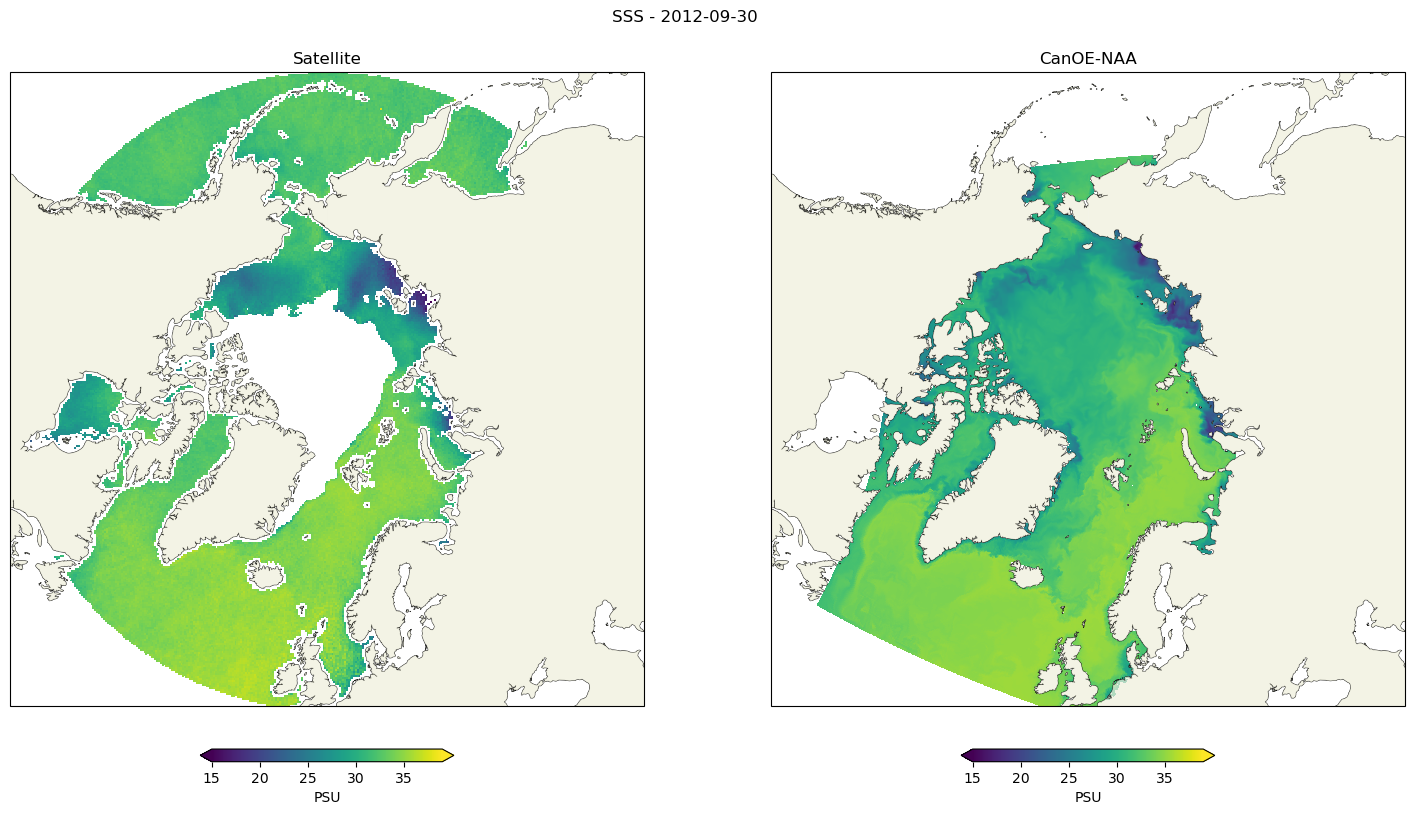

In [8]:
date='2012-09-30'
fig,ax=mplt.initmaps(1,2,figsize=(18,10), extent=[-180,180, 50,90])
fig.suptitle(f'SSS - {date}'); fig.subplots_adjust(top=0.98)
mplt.singleMap(satdata.sel(time=date).sss.squeeze(), satdata.lon, satdata.lat, 
               title='Satellite',unitName='PSU', ax=ax[0],fig=fig,vmin=15,vmax=39);
mplt.singleMap(NAAdata.sel(time=date).squeeze(), NAAdata.nav_lon, NAAdata.nav_lat, landMask=landMask,
                   title='CanOE-NAA',unitName='PSU', ax=ax[1],fig=fig,vmin=15,vmax=39);

#### Regrid

In [9]:
regridder = xe.Regridder(NAAdata.rename({'nav_lat':'lat','nav_lon':'lon'}),
                         satdata.sss.unify_chunks(), 
                         'nearest_s2d', periodic=True,)# ignore_degenerate=True)

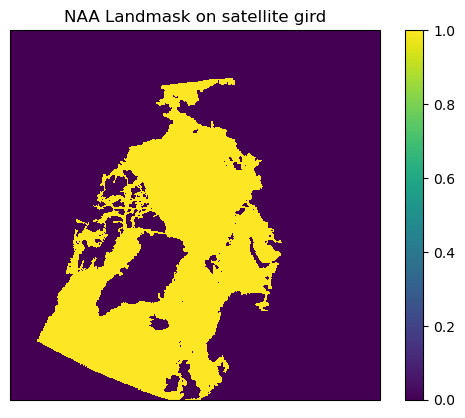

In [10]:
landMask_sat=regridder(landMask)
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent( [-180,180, 50,90], ccrs.PlateCarree() )
pl=ax.pcolormesh(satdata.lon,satdata.lat, landMask_sat,transform=ccrs.PlateCarree(), )
ax.set_title('NAA Landmask on satellite gird');
fig.colorbar(pl)

## Monthly climatologies

In [11]:
SSSmonthClim_sat = satdata.sss.groupby('time.month').mean(keep_attrs=True).compute()
SSSmonthClim_NAA = NAAdata.groupby('time.month').mean(keep_attrs=True).compute()

In [12]:
# regrid naa on sat
SSSmonthClim_NAA_satgrid = regridder(SSSmonthClim_NAA.where(landMask>0))
SSSmonthClim_diff = SSSmonthClim_sat.where((landMask_sat>0)) - SSSmonthClim_NAA_satgrid.where((SSSmonthClim_sat>=0))

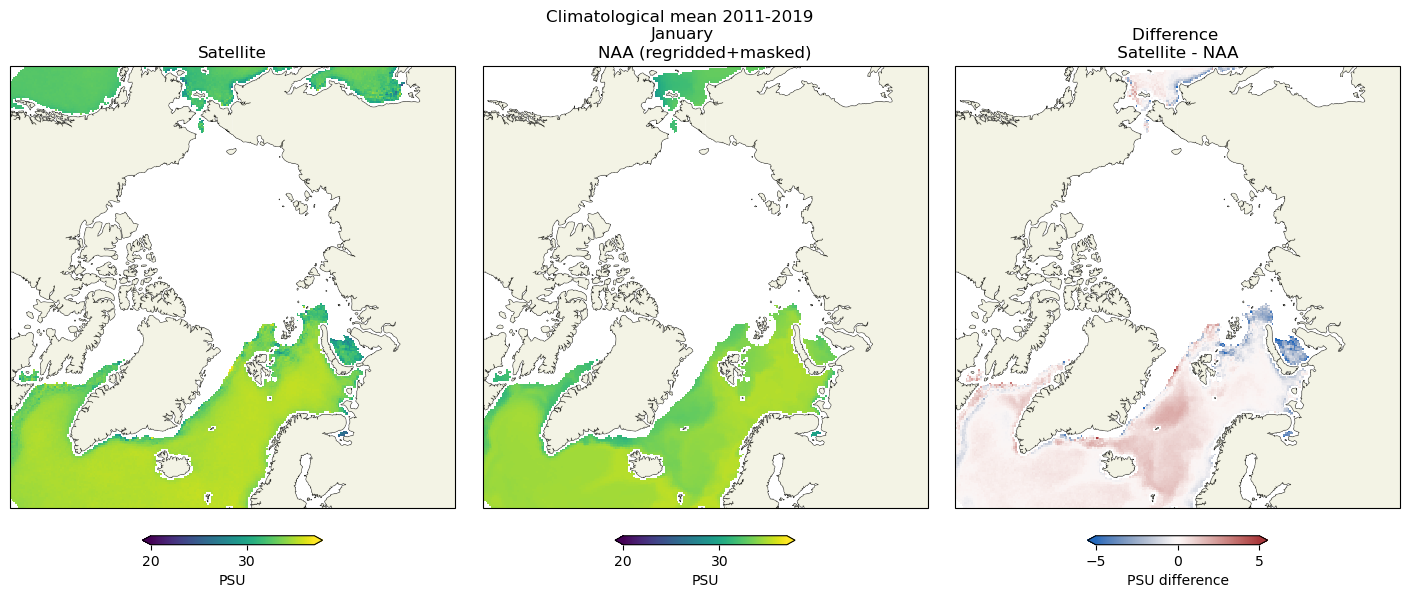

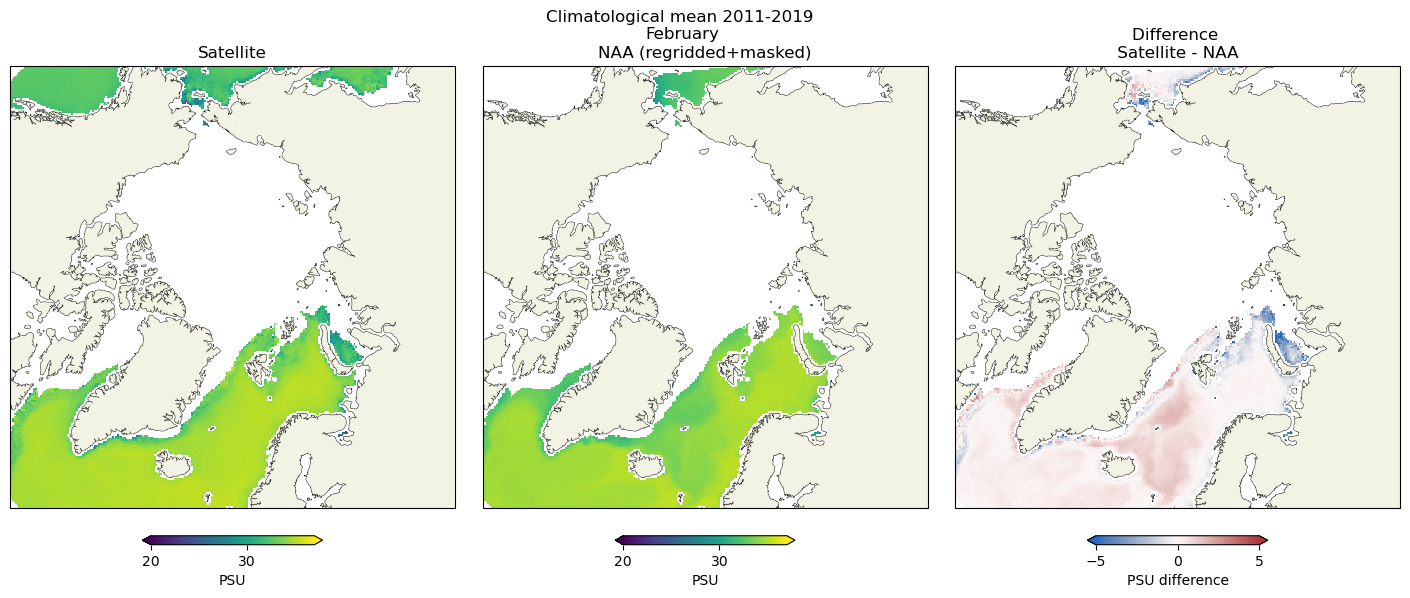

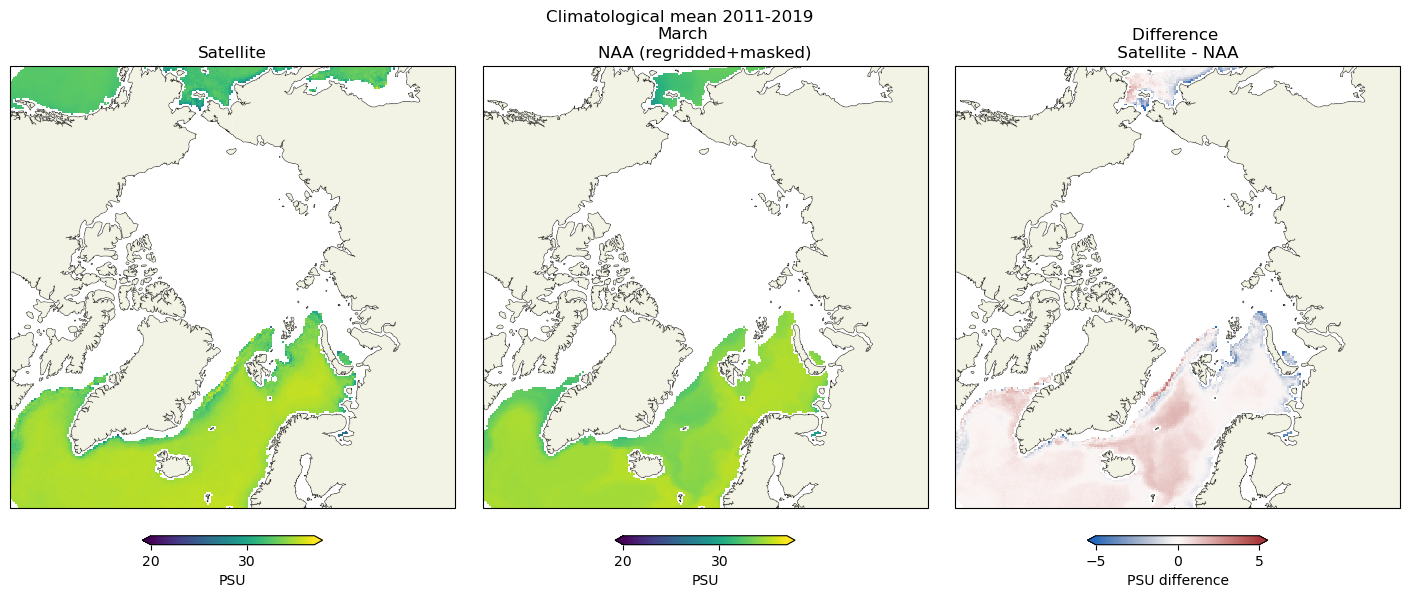

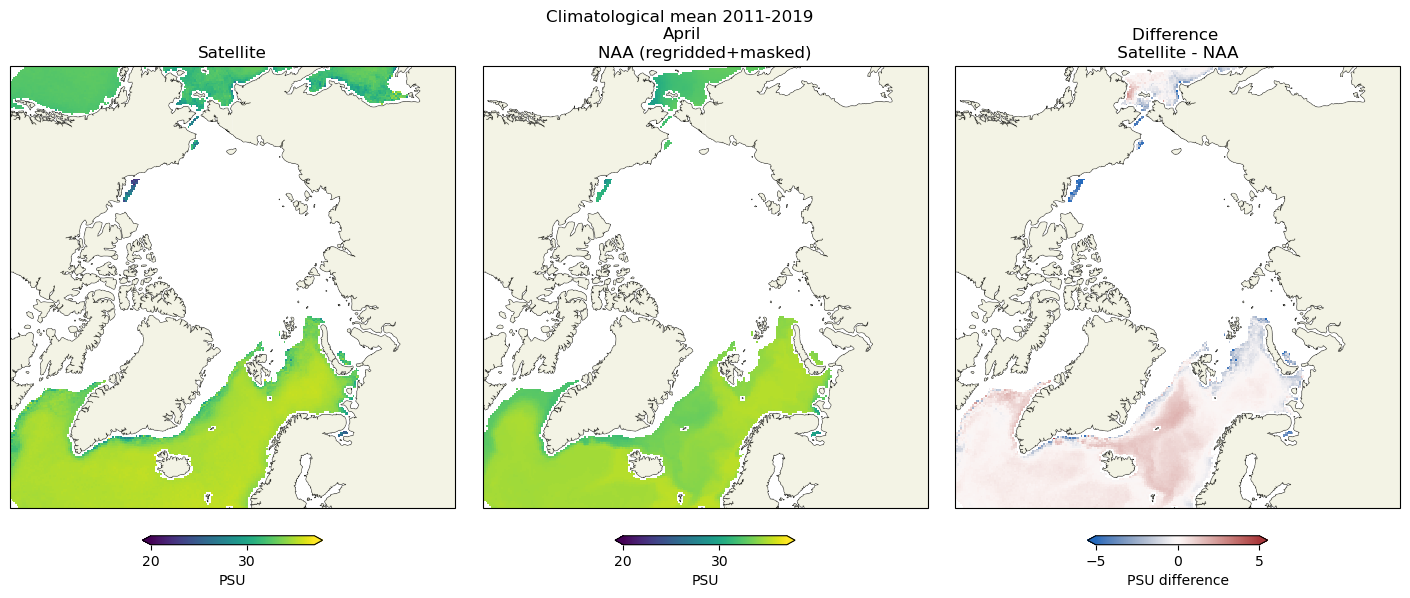

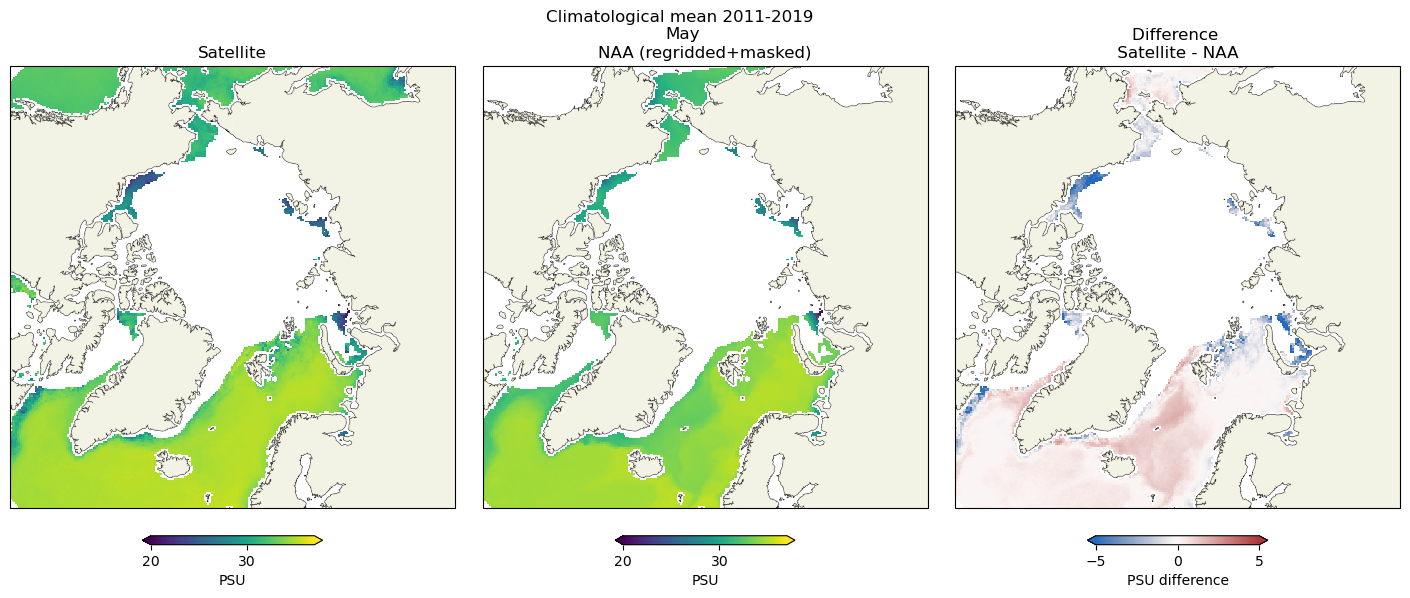

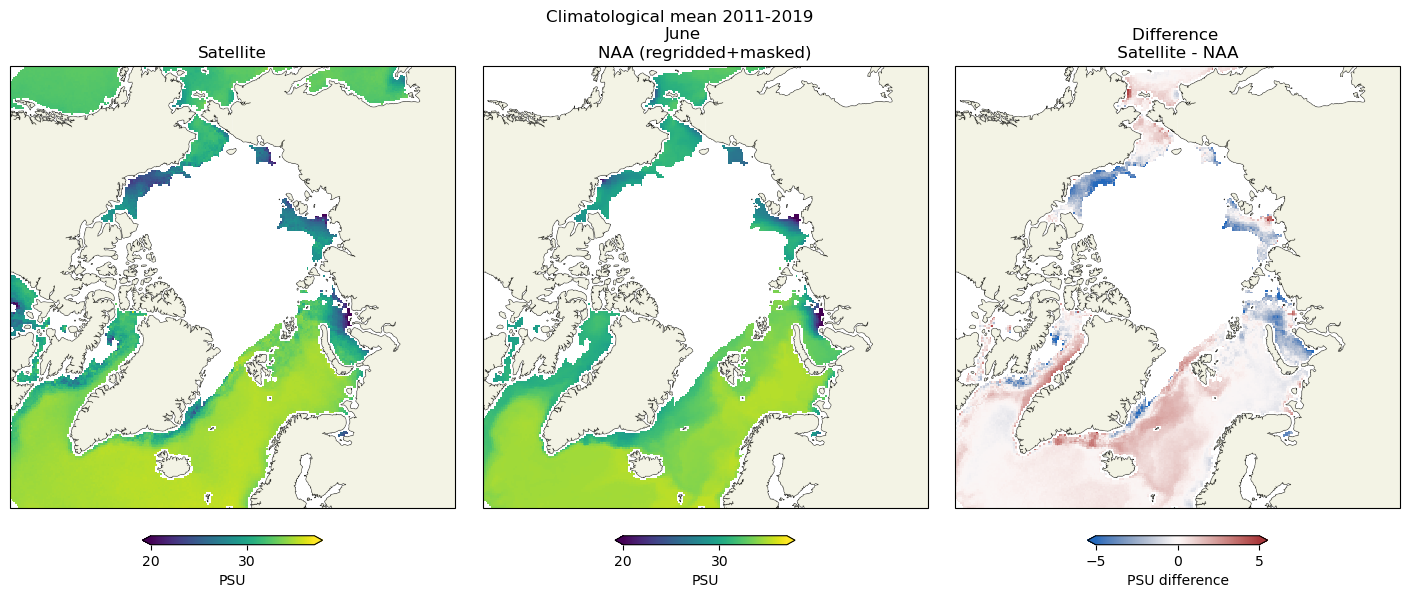

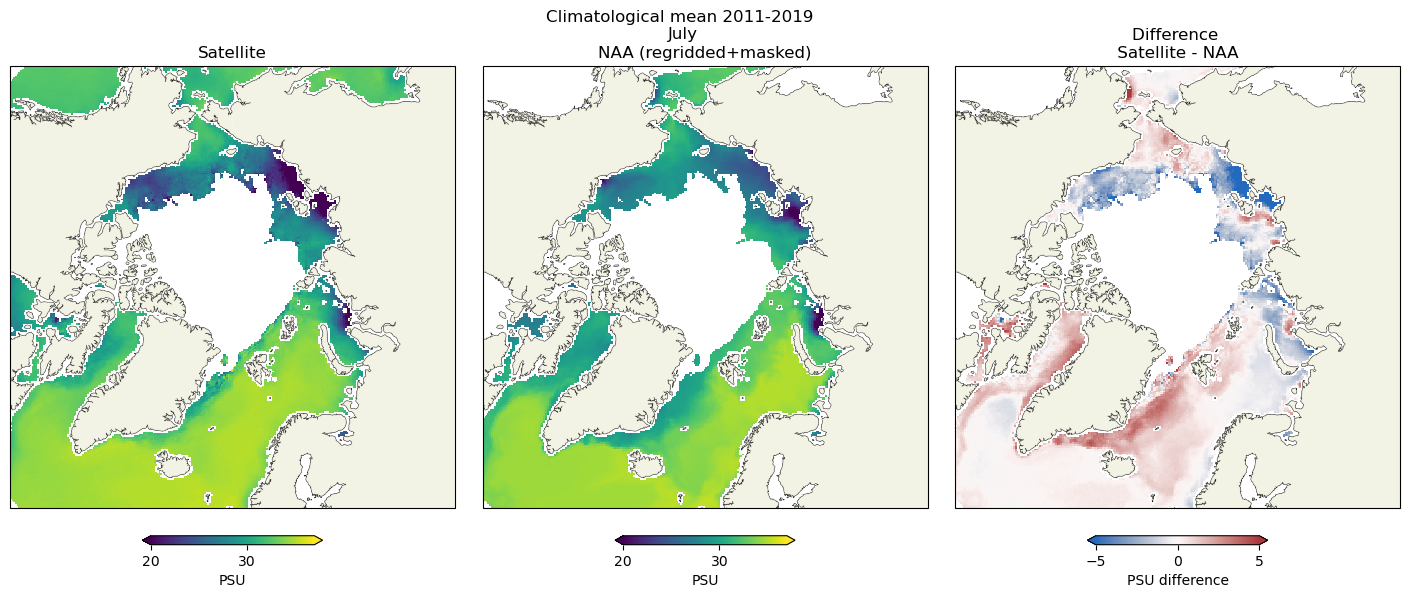

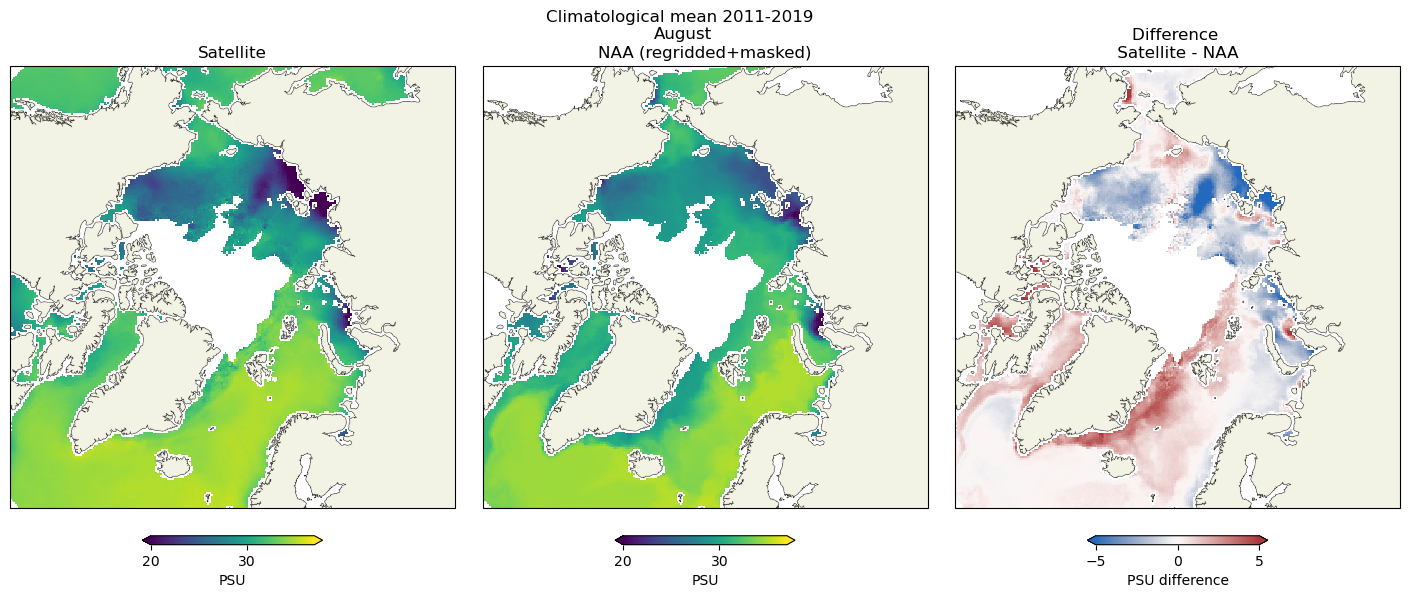

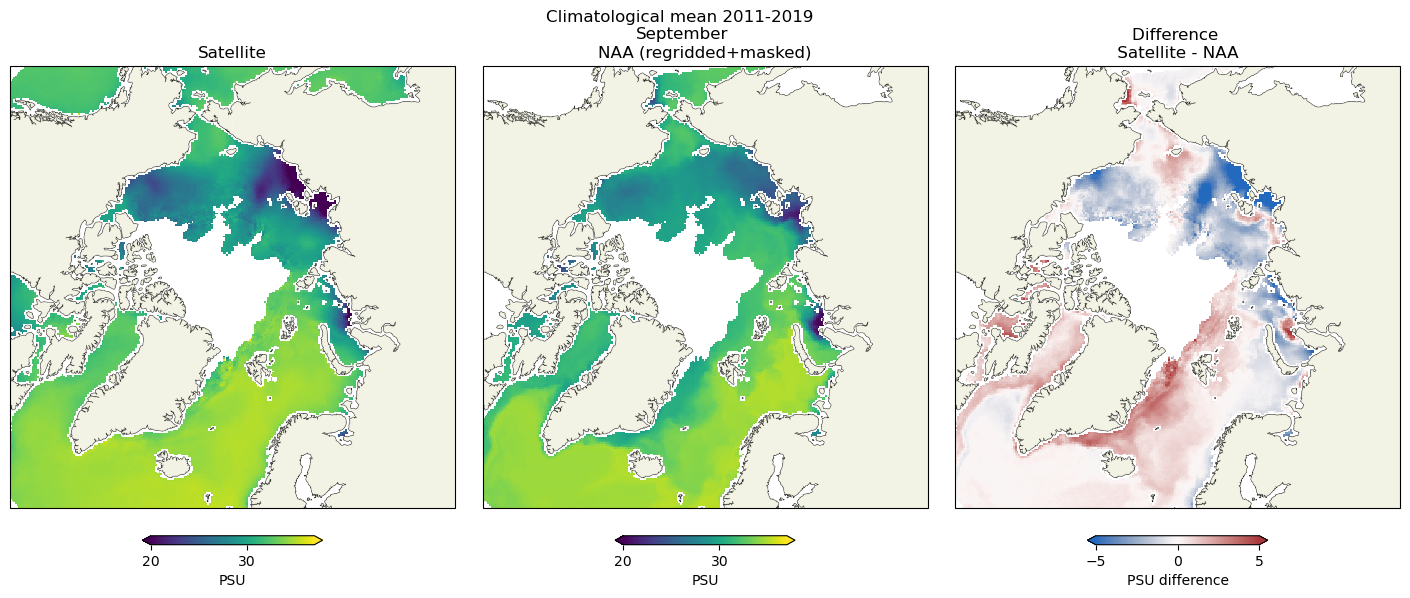

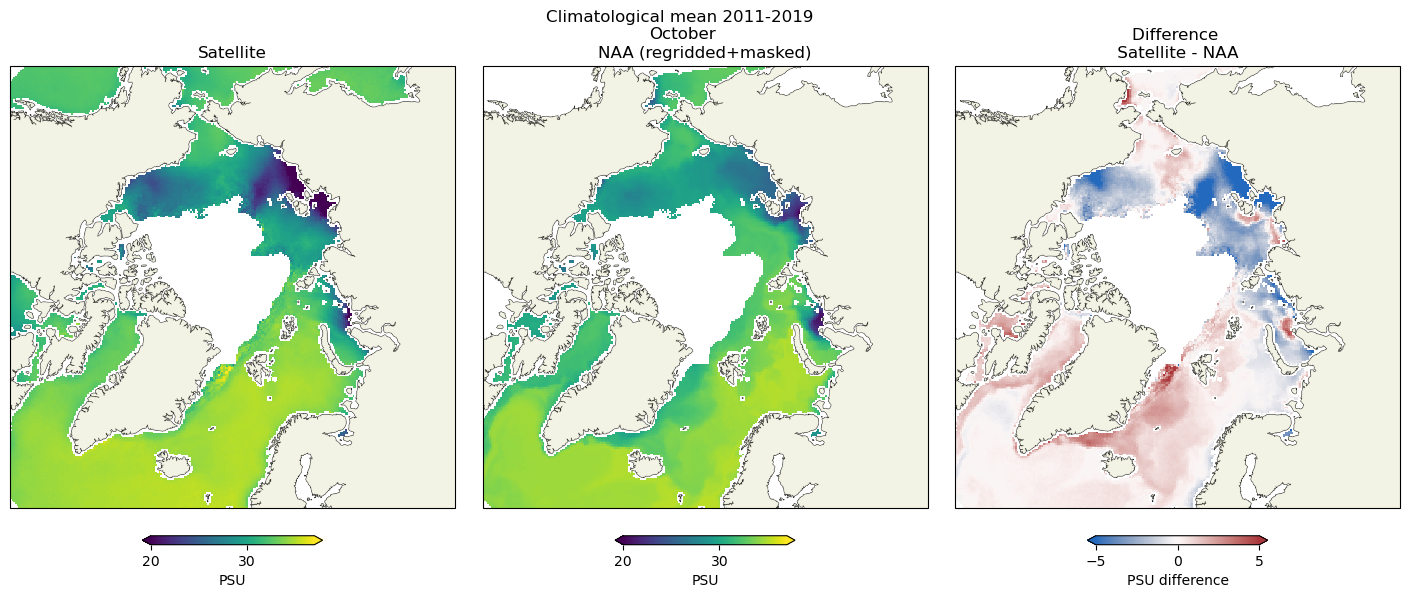

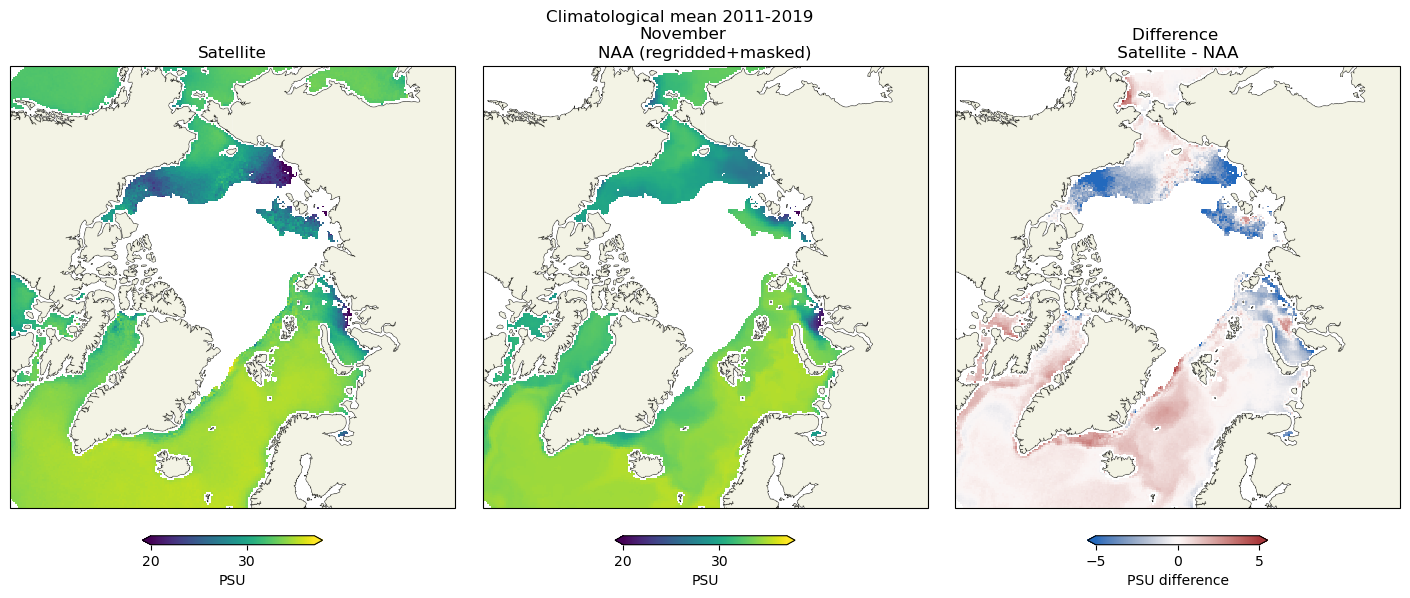

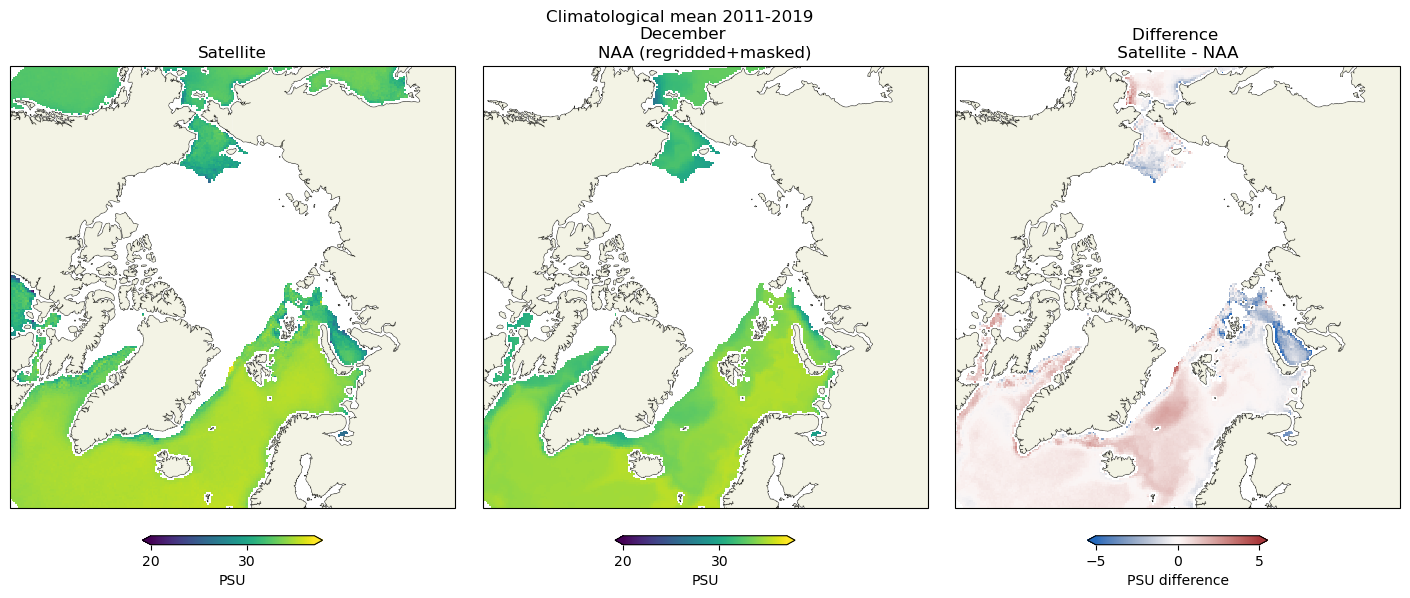

In [14]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
for m in range(12):
    fig,ax=mplt.initmaps(1,3,figsize=(18,7), extent=[-180,180,60,90])
    fig.suptitle(f'Climatological mean 2011-2019 \n{months[m]}'); fig.subplots_adjust(top=0.9,wspace=0.05)
    ## sat
    mplt.singleMap(SSSmonthClim_sat.isel(month=m), satdata.lon, satdata.lat,
                   title='Satellite',unitName='PSU', ax=ax[0],fig=fig,vmin=20,vmax=37);
    ## NAA
    mplt.singleMap(SSSmonthClim_NAA_satgrid.isel(month=m).where((SSSmonthClim_sat.isel(month=m)>=0)&(landMask_sat>0)),
                   satdata.lon, satdata.lat,
                   title='NAA (regridded+masked)',unitName='PSU', ax=ax[1],fig=fig,vmin=20,vmax=37);
    ## Difference
    mplt.singleMap(SSSmonthClim_diff.isel(month=m), satdata.lon, satdata.lat,
                       title='Difference \n Satellite - NAA ',unitName='PSU difference', ax=ax[2],fig=fig,
                       vmin=-5,vmax=5, cmap=sns.color_palette("vlag", as_cmap=True));

## Regional seasonal cycles

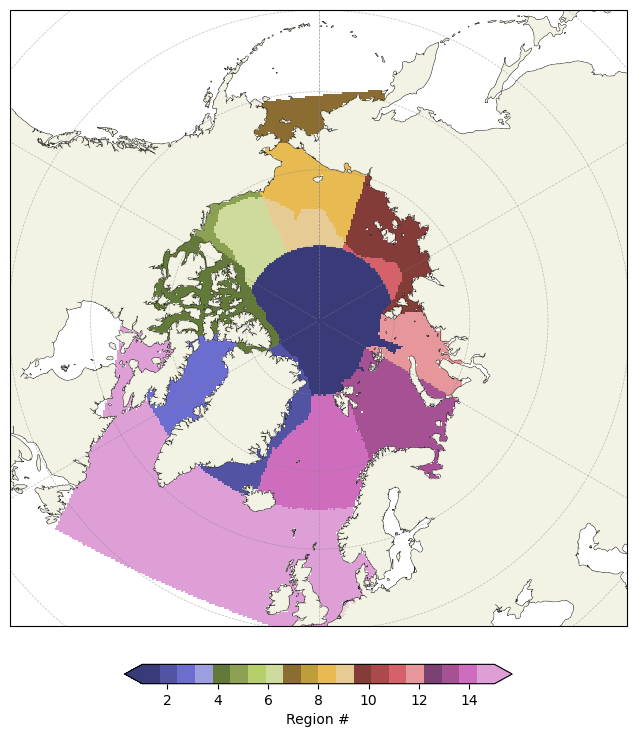

In [20]:
masksNAA = xr.open_dataset('/tsanta/ahaddon/analysis/regional_masks/RegionalMasksNAA.nc')
regions = list(masksNAA.attrs.values())
masksSAT = regridder(masksNAA)
fig,ax=mplt.initmaps(figsize=(10,10),extent=[-180,180, 50,90])
mplt.singleMap(masksSAT.region.where(masksSAT.region>0), satdata.lon, satdata.lat, 
                   unitName='Region #', ax=ax,fig=fig,cmap ='tab20b');

In [ ]:
SSSdailyClim_sat = satdata.sss.groupby('time.dayofyear').mean(keep_attrs=True)
regCycle_SAT = SSSdailyClim_sat.groupby(masksSAT.region).mean(dim=['x','y'],keep_attrs=True).compute()
NAAdata_regridMask = regridder(NAAdata.where(landMask>0)).where((satdata.sss>=0))
SSSdailyClim_NAA = NAAdata_regridMask.groupby('time.dayofyear').mean(keep_attrs=True)
regCycle_NAA = SSSdailyClim_NAA.groupby(masksSAT.region).mean(dim=['x','y'],keep_attrs=True).compute()

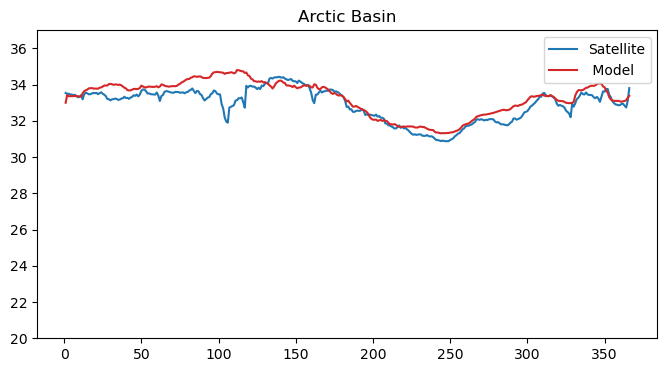

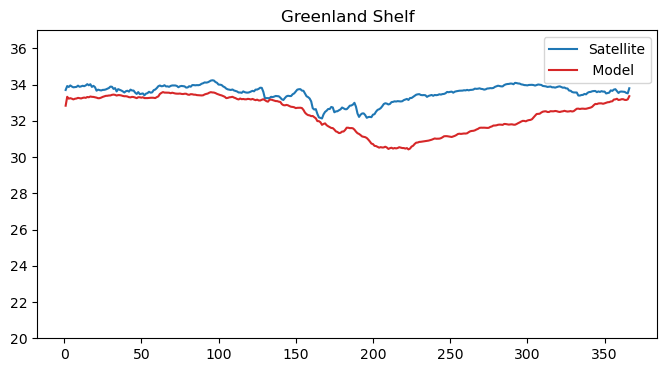

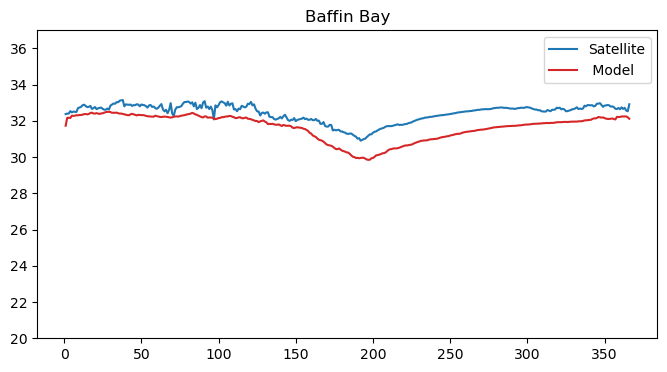

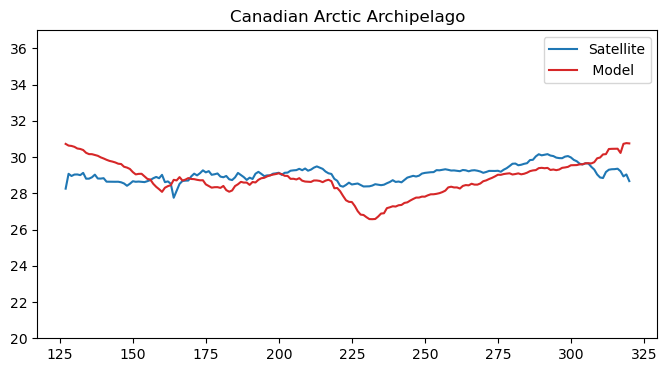

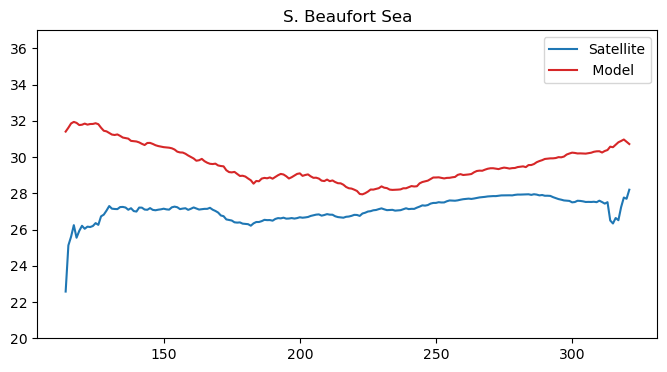

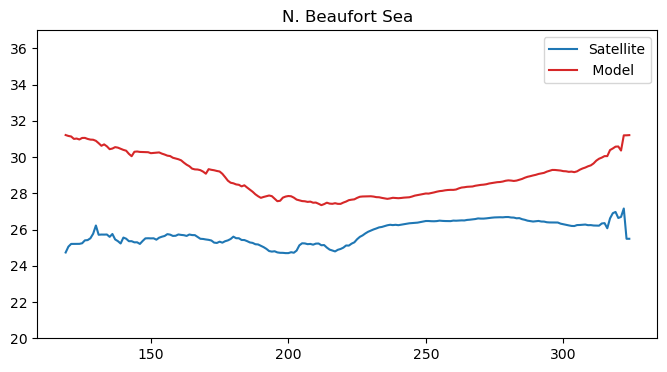

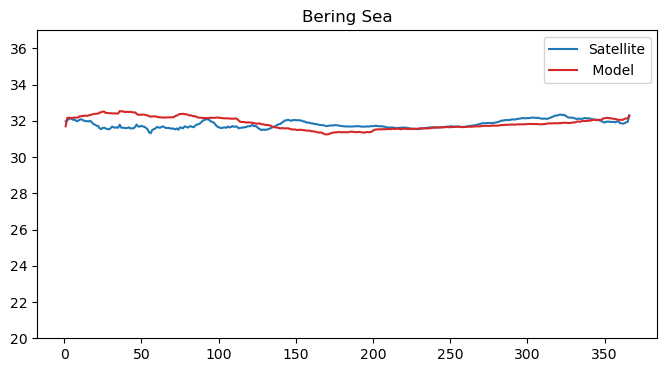

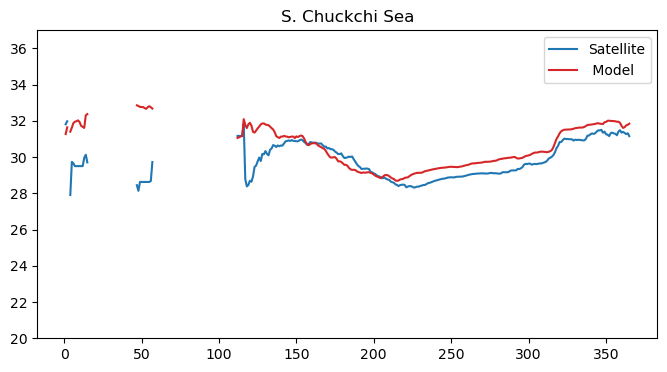

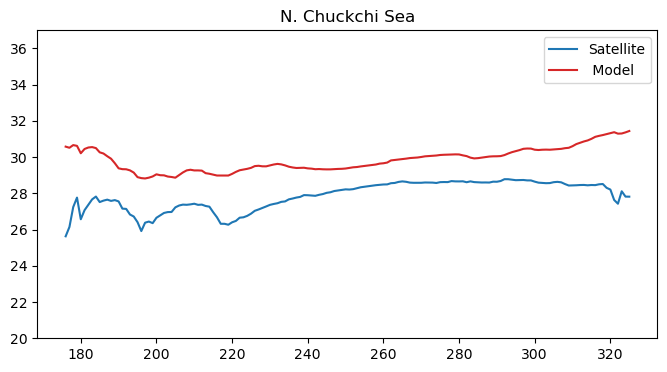

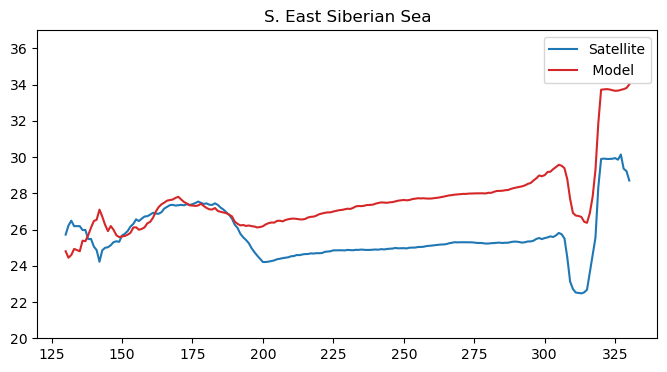

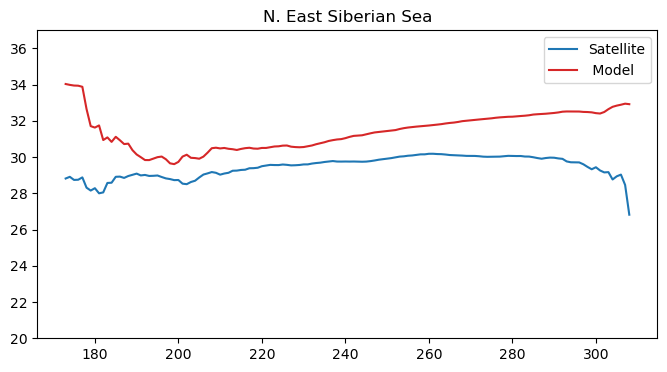

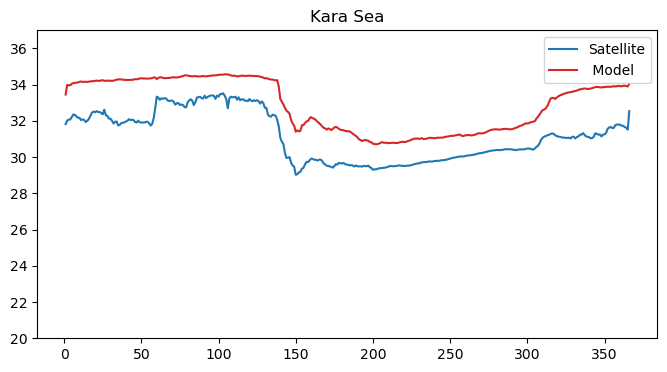

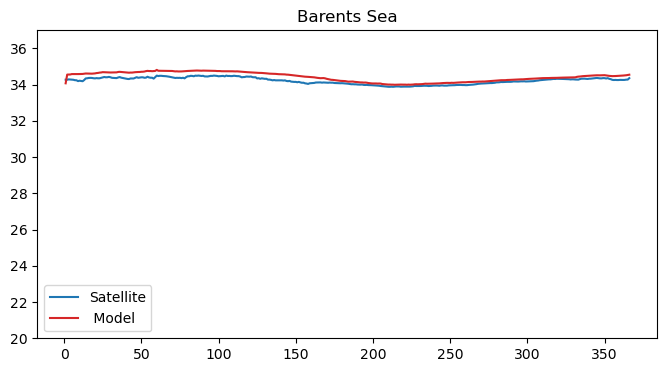

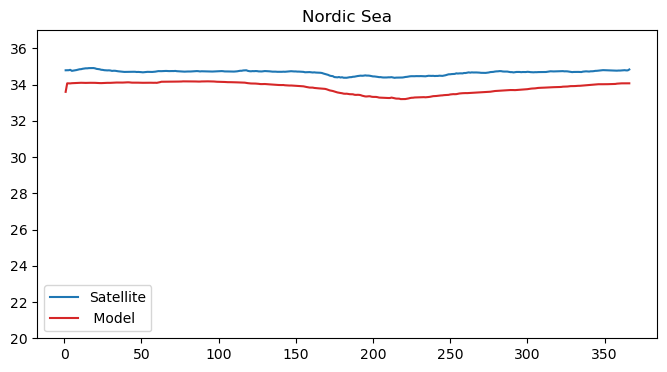

In [29]:
for ir,rgn in enumerate(regions):
    fig,ax=plt.subplots(figsize=(8,4))
    ax.set_title(rgn)
    ax.plot(regCycle_SAT.dayofyear, regCycle_SAT.sel(region=ir+1), 'tab:blue', label='Satellite')
    ax.plot(regCycle_NAA.dayofyear, regCycle_NAA.sel(region=ir+1), 'tab:red', label=' Model')
    ax.set_ylim(20,37)
    ax.legend()